## Get Backend

In [1]:
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider()

backends_info = {
    'ibm_canberra' : "q-info-hackathon/team-21/main",
    'ibmq_mumbai' : "ibm-q-skku/hackathon-2023/hackathon",
    'ibm_hanoi' : 'ibm-q-skku/hackathon-2023/hackathon'
    }

backend_name, instance = list(backends_info.items())[0]

backend = provider.get_backend(backend_name, instance=instance)
print(f"Using {backend.name}")

Using ibm_canberra


## Make and Transpile Circuits

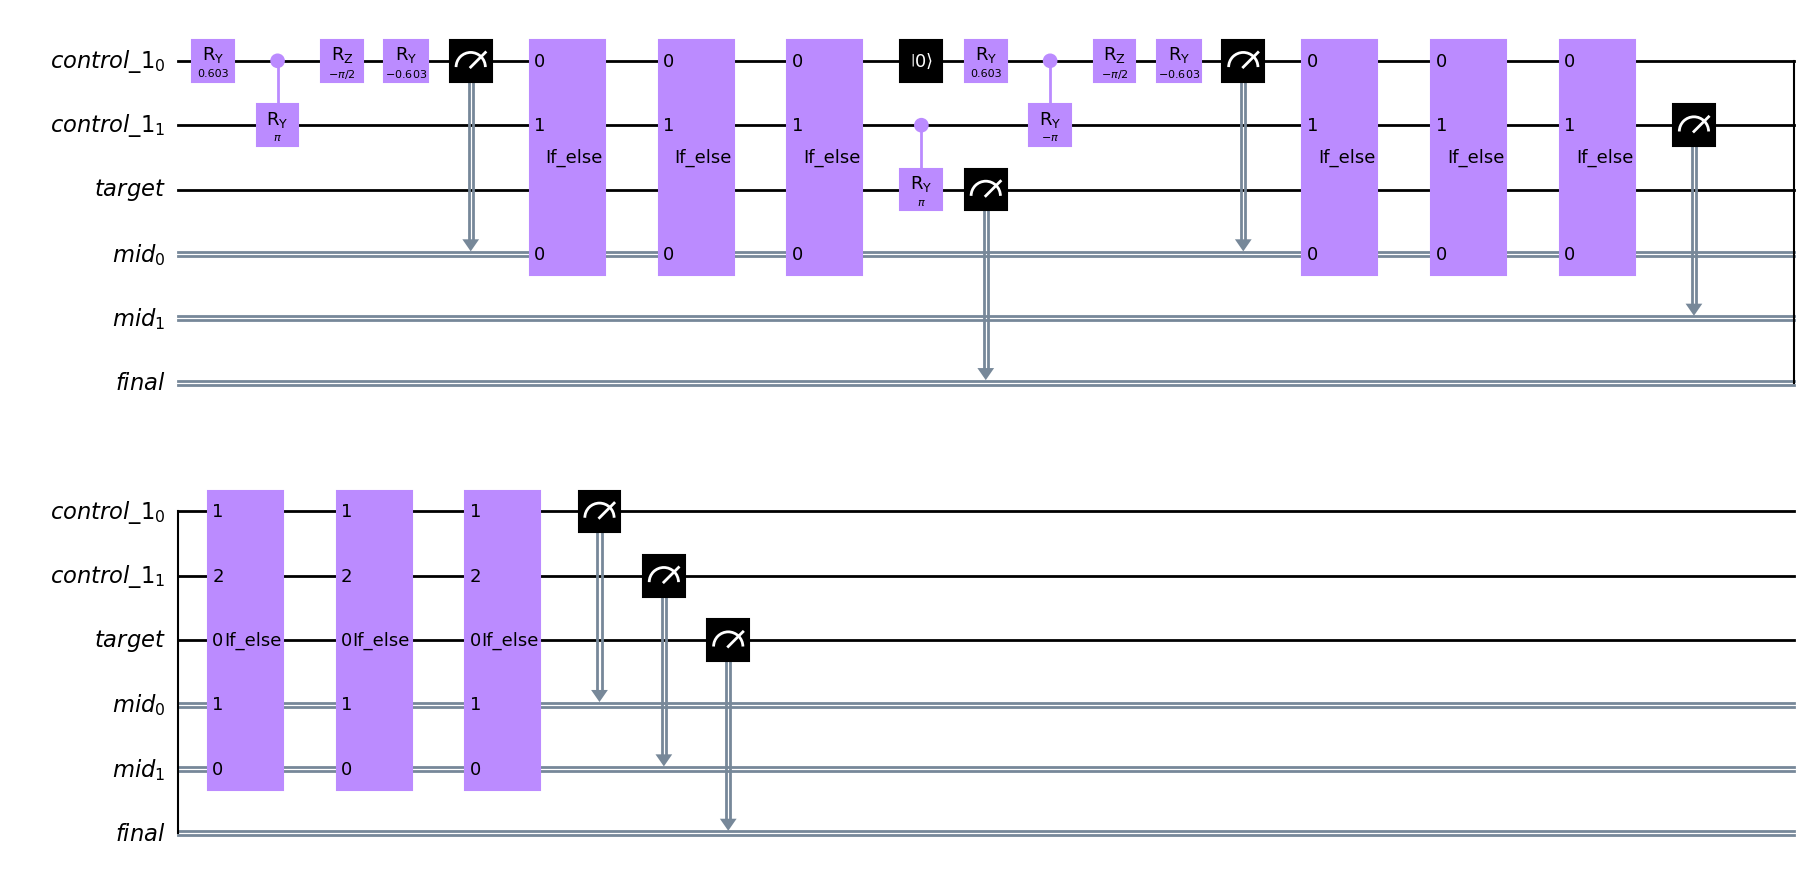

In [139]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def trial(circuit, target, control, theta, measure):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.ry(2*theta, control)
    circuit.cy(control, target)
    circuit.rz(-np.pi/2, control)
    circuit.ry(-2*theta, control)
    circuit.measure(control, measure)

def repeat_block(circuit, target, control, theta, measure):
    with circuit.if_test((measure, 0)) as else_:
        pass
    with else_:
        # Reset the control and target.
        circuit.x(control)
        circuit.ry(-np.pi/2, target)
        # Then repeat the trial.
        trial(circuit, target, control, theta, measure)

def RUS_circuit_1fold(theta, max_trials=2):
    control = QuantumRegister(1, name="control")
    target = QuantumRegister(1, name="target")
    mid_measure = ClassicalRegister(1, name="mid")
    final_measure = ClassicalRegister(1, name="final")
    circuit = QuantumCircuit(control, target, mid_measure, final_measure)

    # make circuit
    trial(circuit, target, control, theta, mid_measure)
    for _ in range(max_trials - 1): repeat_block(circuit, target, control, theta, mid_measure)
    circuit.measure(control, mid_measure)
    circuit.measure(target, final_measure)

    return circuit

def RUS_circuit_2fold(theta, max_trials=2):
    
    def trial(circuit, target, control, theta, measure, y_phase):
        # make circuit
        circuit.ry(2*theta, control)
        if y_phase == 'i':
            circuit.cry(-np.pi, control, target)
        elif y_phase == '-i':
            circuit.cry(np.pi, control, target)
        circuit.rz(-np.pi/2, control)
        circuit.ry(-2*theta, control)
        circuit.measure(control, measure)
    
    def trial_2(circuit, target, control, theta, mid_measure):
        trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')
        for _ in range(max_trials - 1):
            with circuit.if_test((mid_measure[0], 0)) as else_:
                pass
            with else_:
                # Reset the control and target.
                circuit.x(control[0])
                circuit.ry(-np.pi, control[1])
                # Then repeat the trial.
                trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')

        circuit.cry(np.pi, control[1], target)
        circuit.reset(control[0])
        
        trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')
        for _ in range(max_trials - 1):
            with circuit.if_test((mid_measure[0], 0)) as else_:
                pass
            with else_:
                # Reset the control and target.
                circuit.x(control[0])
                circuit.ry(-np.pi, control[1])
                # Then repeat the trial.
                trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')

    control = QuantumRegister(2, name="control_1")
    target = QuantumRegister(1, name="target")
    mid_measure = ClassicalRegister(2, name="mid")
    
    final_measure = ClassicalRegister(1, name="final")
    circuit = QuantumCircuit(control, target, mid_measure, final_measure)

    trial_2(circuit, target, control, theta, mid_measure)

    circuit.measure(control[1], mid_measure[1])
    circuit.measure(target, final_measure)

    for _ in range(max_trials - 1):
        with circuit.if_test((mid_measure[1], 0)) as else_:
            pass
        with else_:
            # Reset the control and target.
            circuit.x(control[1])
            circuit.ry(-np.pi, target)
            # Then repeat the trial.
            trial_2(circuit, target, control, theta, mid_measure)

    circuit.measure(control, mid_measure)
    circuit.measure(target, final_measure)

    return circuit

thetas = np.linspace(0, np.pi/2, 100)
circuits_1fold = []
circuits_2fold = []

for i, theta in enumerate(thetas):
    circuits_1fold.append(RUS_circuit_1fold(theta, max_trials=4))
    circuits_2fold.append(RUS_circuit_2fold(theta, max_trials=2))

# transpile
builts_1fold = [transpile(circuits_1fold[i], backend) for i in range(len(circuits_1fold))]
builts_2fold = [transpile(circuits_2fold[i], backend) for i in range(len(circuits_2fold))]

circuits_2fold[19].draw('mpl')

## Get Result From Simul (1fold)

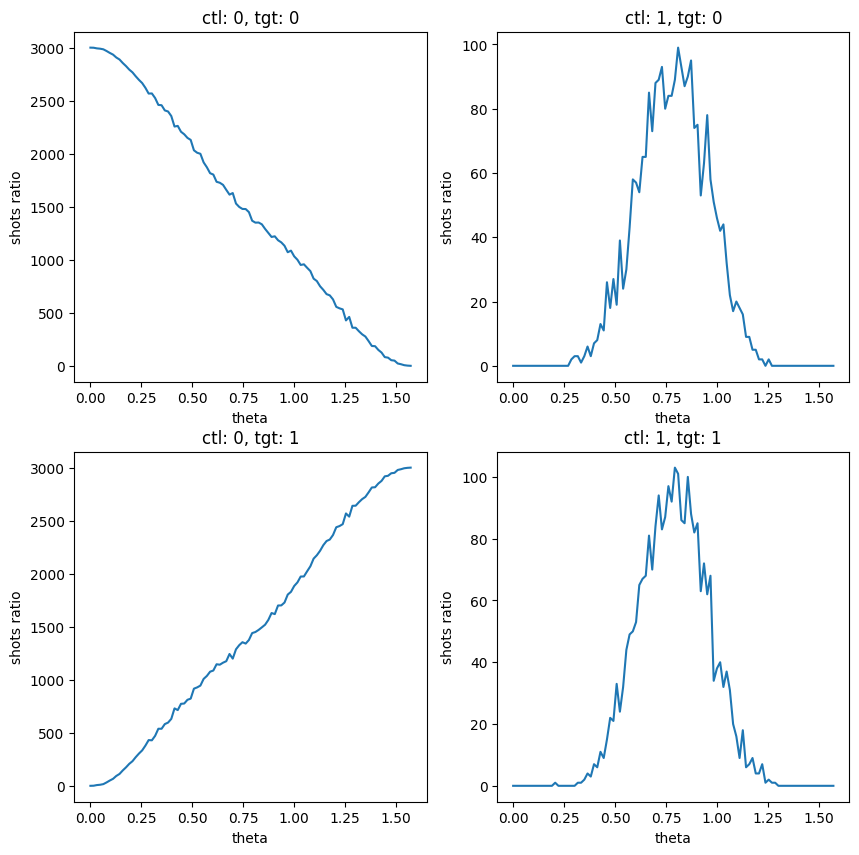

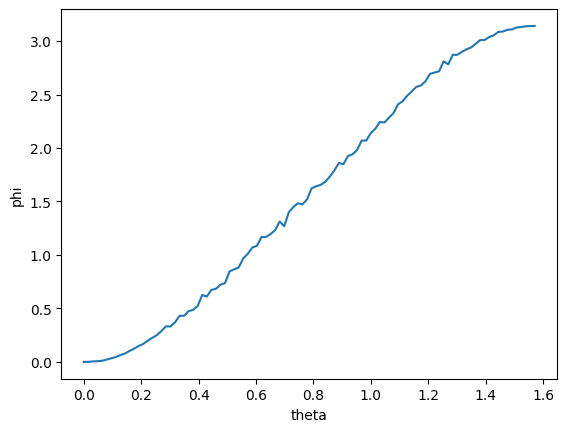

In [117]:
import numpy as np

# simulate
sim = AerSimulator(method="statevector")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plot_data = [{'x':thetas, 'y':[]} for _ in range(4)]

num_shots = 3000

for built in builts_1fold:

    simulator_result = sim.run(built, shots=num_shots).result()
    simulator_counts = simulator_result.get_counts()
    # print(simulator_counts)
    keys = ['0 0', '0 1', '1 0', '1 1']
    for k in keys :
        if k not in simulator_counts.keys():
            simulator_counts[k] = 0
    
    for k, v in simulator_counts.items():
        for k_ in keys:
            if k == k_:
                plot_data[keys.index(k_)]['y'].append(v)

for i, data in enumerate(plot_data):
    axs[i//2, i%2].plot(data['x'], data['y'])
    axs[i//2, i%2].title.set_text(f'ctl: {keys[i][2:]}, tgt: {keys[i][0]}')
    axs[i//2, i%2].set(xlabel="theta", ylabel="shots ratio")

plt.show()
plt.close()

final_0 = plot_data[0]['y']
final_1 = plot_data[2]['y']
phi_list = []
for i in range(len(final_0)):
    phi_list.append(2*np.arctan(final_1[i]/final_0[i]) if final_0[i] != 0 else np.pi)
    
plt.figure()
plt.plot(data['x'], phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()

## Get Result From Simul (2fold)

{'0 00': 3000}
{'1 00': 1, '0 00': 2999}
{'1 00': 2, '0 00': 2998}
{'1 00': 5, '0 00': 2995}
{'1 00': 13, '0 00': 2987}
{'1 00': 21, '0 10': 1, '0 00': 2978}
{'1 00': 23, '0 00': 2977}
{'1 10': 1, '1 00': 33, '0 10': 1, '0 00': 2965}
{'1 10': 1, '1 00': 48, '0 00': 2951}
{'1 10': 5, '1 00': 74, '0 10': 3, '0 00': 2918}
{'1 10': 7, '1 00': 61, '0 10': 5, '0 00': 2927}
{'1 10': 6, '1 00': 86, '0 10': 6, '0 00': 2902}
{'1 10': 6, '1 00': 110, '0 10': 10, '0 00': 2874}
{'1 10': 11, '1 00': 115, '0 10': 10, '0 00': 2864}
{'1 10': 26, '1 00': 123, '0 10': 16, '0 00': 2835}
{'1 10': 10, '1 00': 160, '0 10': 15, '0 00': 2815}
{'1 10': 18, '1 00': 173, '0 10': 18, '0 00': 2791}
{'1 10': 32, '1 00': 175, '0 10': 26, '0 00': 2767}
{'1 00': 191, '1 10': 41, '0 10': 35, '0 00': 2733}
{'1 10': 46, '1 00': 234, '0 10': 34, '0 00': 2686}
{'1 10': 50, '1 00': 231, '0 10': 36, '0 00': 2683}
{'1 10': 48, '1 00': 260, '0 10': 53, '0 00': 2639}
{'1 10': 58, '1 00': 272, '0 10': 59, '0 00': 2611}
{'1 10': 6

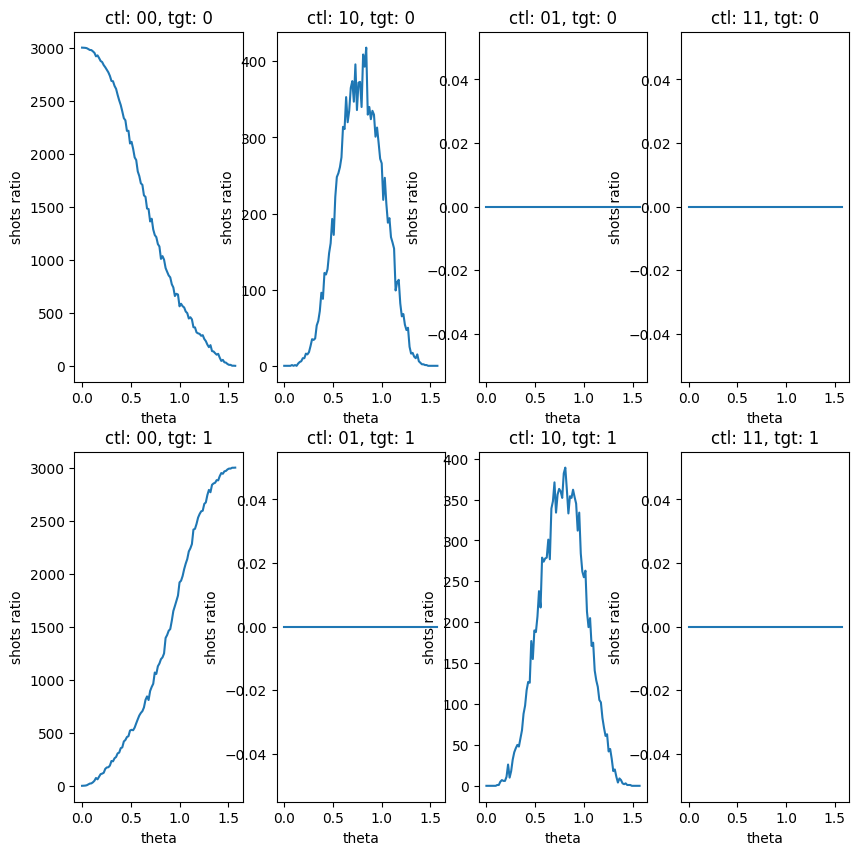

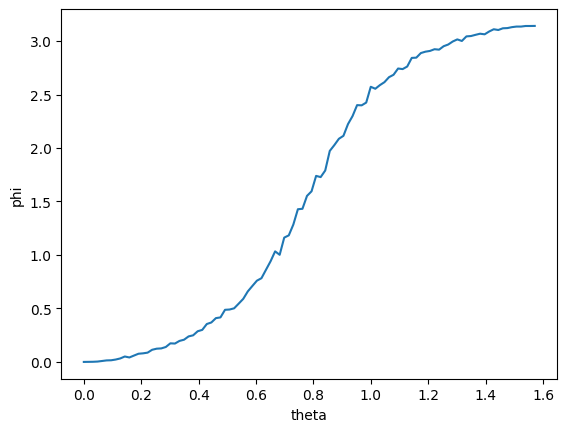

In [131]:
# simulate
sim = AerSimulator(method="statevector")

qubit_num = 3

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))

plot_data = [{'x':thetas, 'y':[]} for _ in range(2**3)]

num_shots = 3000

for built in builts_2fold:

    simulator_result = sim.run(built, shots=num_shots).result()
    simulator_counts = simulator_result.get_counts()
    print(simulator_counts)
    keys = ['0 00', '0 10', '0 01', '0 11', '1 00', '1 01', '1 10', '1 11']
    for k in keys :
        if k not in simulator_counts.keys():
            simulator_counts[k] = 0
    
    for k, v in simulator_counts.items():
        for k_ in keys:
            if k == k_:
                plot_data[keys.index(k_)]['y'].append(v)

for i, data in enumerate(plot_data):
    axs[i//4, i%4].plot(data['x'], data['y'])
    axs[i//4, i%4].title.set_text(f'ctl: {keys[i][2:]}, tgt: {keys[i][0]}')
    axs[i//4, i%4].set(xlabel="theta", ylabel="shots ratio")

plt.show()
plt.close()

final_0 = plot_data[0]['y']
final_1 = plot_data[4]['y']
phi_list = []
for i in range(len(final_0)):
    phi_list.append(2*np.arctan(final_1[i]/final_0[i]) if final_0[i] != 0 else np.pi)
    
plt.figure()
plt.plot(data['x'], phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()

## Get Result From Backend (1fold)

In [158]:
# Recall that `built = transpile(circuit, backend)`.
points = [0, 6, 13, 19, 25, 31, 38, 44, 50, 56, 63, 69, 75, 81, 88, 94, 99]
thetas_actual = [thetas[i] for i in points]
builts_1fold_actual = [builts_1fold[i] for i in points]
hardware_counts_1fold = []
for built in builts_1fold_actual:
    job = backend.run(built, dynamic=True)
    job.job_id()
    hardware_counts_1fold.append(job.result().get_counts())

In [159]:
print(hardware_counts_1fold)

[{'0 0': 3901, '0 1': 33, '1 0': 62, '1 1': 4}, {'0 0': 3824, '0 1': 32, '1 0': 142, '1 1': 2}, {'0 0': 3612, '0 1': 36, '1 0': 340, '1 1': 12}, {'0 0': 3435, '0 1': 22, '1 0': 536, '1 1': 7}, {'0 0': 3141, '0 1': 48, '1 0': 786, '1 1': 25}, {'0 0': 2824, '0 1': 50, '1 0': 1084, '1 1': 42}, {'0 0': 2472, '0 1': 98, '1 0': 1317, '1 1': 113}, {'0 0': 2147, '0 1': 149, '1 0': 1566, '1 1': 138}, {'0 0': 1932, '0 1': 103, '1 0': 1824, '1 1': 141}, {'0 0': 1674, '0 1': 100, '1 0': 2097, '1 1': 129}, {'0 0': 1376, '0 1': 57, '1 0': 2482, '1 1': 85}, {'0 0': 1132, '0 1': 43, '1 0': 2782, '1 1': 43}, {'0 0': 830, '0 1': 22, '1 0': 3108, '1 1': 40}, {'0 0': 583, '0 1': 21, '1 0': 3366, '1 1': 30}, {'0 0': 337, '0 1': 5, '1 0': 3635, '1 1': 23}, {'0 0': 219, '0 1': 6, '1 0': 3747, '1 1': 28}, {'0 0': 186, '0 1': 5, '1 0': 3790, '1 1': 19}]


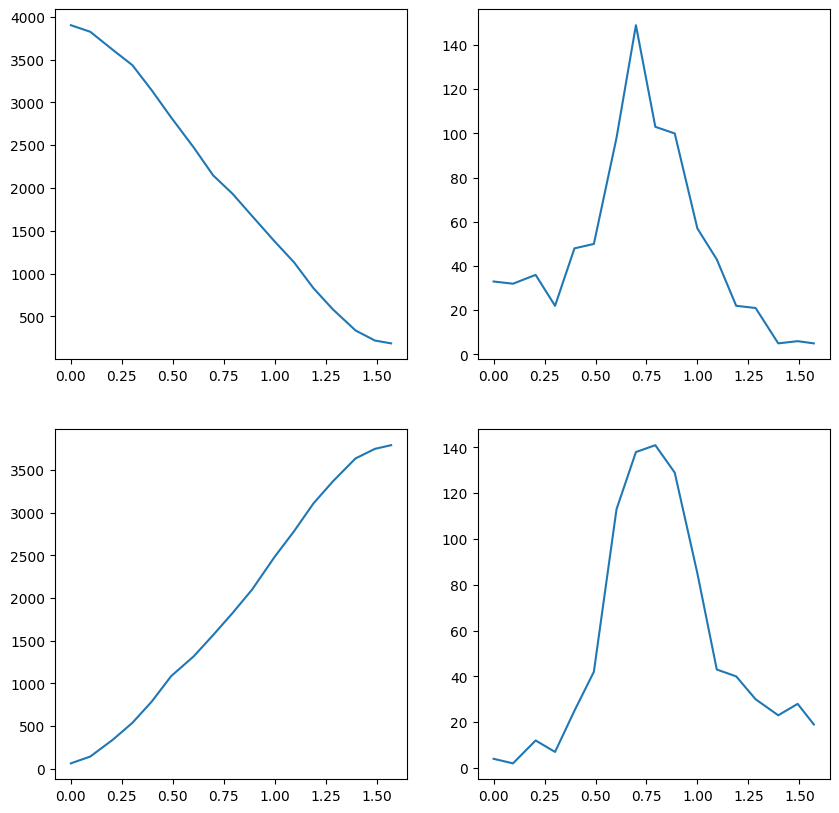

In [162]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

count_00, count_01, count_10, count_11 = [], [], [], []
for count in hardware_counts_1fold:
    if '0 0' in count.keys() : count_00.append(count['0 0'])
    else : count_00.append(0)
    if '0 1' in count.keys() : count_01.append(count['0 1'])
    else : count_01.append(0)
    if '1 0' in count.keys() : count_10.append(count['1 0'])
    else : count_10.append(0)
    if '1 1' in count.keys() : count_11.append(count['1 1'])
    else : count_11.append(0)
    
axes[0, 0].plot(thetas_actual, count_00)
axes[0, 1].plot(thetas_actual, count_01)
axes[1, 0].plot(thetas_actual, count_10)
axes[1, 1].plot(thetas_actual, count_11)

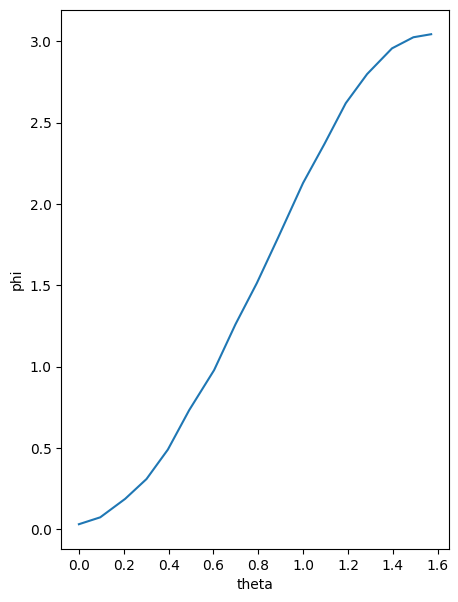

In [170]:
phi_list = []
for i in range(len(count_00)):
    phi_list.append(2*np.arctan(count_10[i]/count_00[i]) if final_0[i] != 0 else np.pi)

plt.figure(figsize=(5, 7))
plt.plot(thetas_actual, phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()

## Get Result From Backend (2fold)

In [153]:
# Recall that `built = transpile(circuit, backend)`.
points = [0, 6, 13, 19, 25, 31, 38, 44, 50, 56, 63, 69, 75, 81, 88, 94, 99]
thetas_actual = [thetas[i] for i in points]
builts_2fold_actual = [builts_2fold[i] for i in points]
hardware_counts_2fold = []
for built in builts_2fold_actual:
    job = backend.run(built, dynamic=True)
    job.job_id()
    hardware_counts_2fold.append(job.result().get_counts())

In [150]:
print(hardware_counts_2fold)

[{'0 00': 3316, '0 01': 21, '0 10': 145, '0 11': 2, '1 00': 445, '1 10': 70, '1 11': 1}, {'0 00': 2986, '0 01': 17, '0 10': 265, '0 11': 3, '1 00': 539, '1 01': 2, '1 10': 187, '1 11': 1}, {'0 00': 2430, '0 01': 12, '0 10': 594, '0 11': 10, '1 00': 542, '1 01': 4, '1 10': 405, '1 11': 3}, {'0 00': 1800, '0 01': 31, '0 10': 946, '0 11': 33, '1 00': 597, '1 01': 10, '1 10': 565, '1 11': 18}, {'0 00': 1283, '0 01': 44, '0 10': 1147, '0 11': 56, '1 00': 779, '1 01': 32, '1 10': 635, '1 11': 24}, {'0 00': 1122, '0 01': 24, '0 10': 941, '0 11': 22, '1 00': 1214, '1 01': 40, '1 10': 618, '1 11': 19}, {'0 00': 1105, '0 01': 10, '0 10': 776, '0 11': 7, '1 00': 1649, '1 01': 20, '1 10': 426, '1 11': 7}, {'0 00': 1225, '0 10': 403, '0 11': 2, '1 00': 2180, '1 01': 11, '1 10': 177, '1 11': 2}, {'0 00': 1266, '0 01': 4, '0 10': 391, '0 11': 2, '1 00': 2221, '1 01': 14, '1 10': 102}]


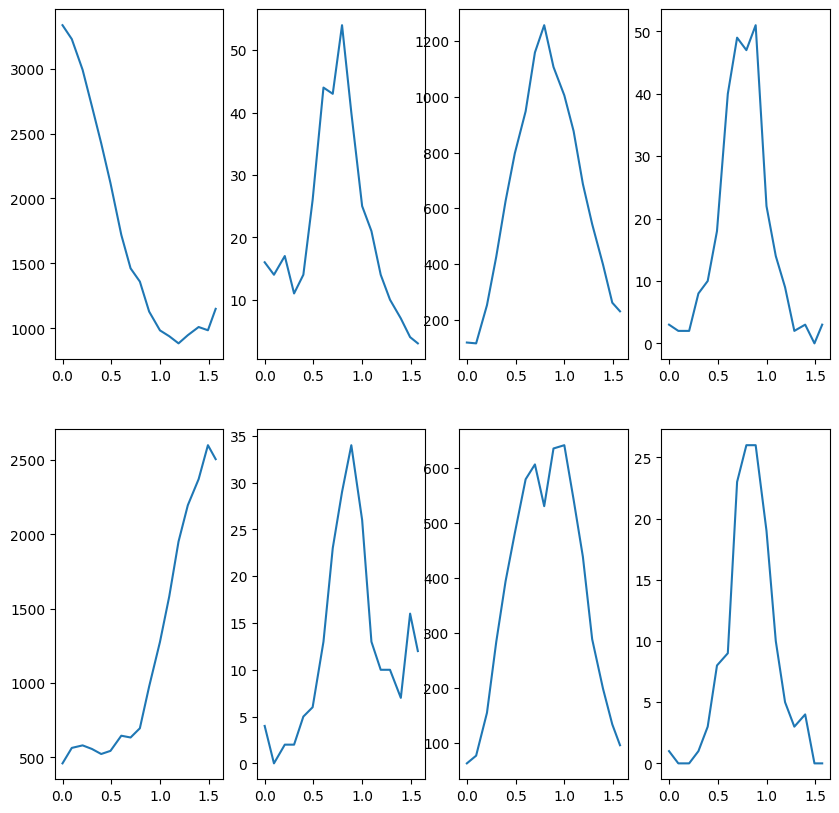

In [154]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))

count_000, count_001, count_010, count_011, count_100, count_101, count_110, count_111 = [], [], [], [], [], [], [], []
for count in hardware_counts_2fold:
    if '0 00' in count.keys() : count_000.append(count['0 00'])
    else : count_000.append(0)
    if '0 01' in count.keys() : count_001.append(count['0 01'])
    else : count_001.append(0)
    if '0 10' in count.keys() : count_010.append(count['0 10'])
    else : count_010.append(0)
    if '0 11' in count.keys() : count_011.append(count['0 11'])
    else : count_011.append(0)
    if '1 00' in count.keys() : count_100.append(count['1 00'])
    else : count_100.append(0)
    if '1 01' in count.keys() : count_101.append(count['1 01'])
    else : count_101.append(0)
    if '1 10' in count.keys() : count_110.append(count['1 10'])
    else : count_110.append(0)
    if '1 11' in count.keys() : count_111.append(count['1 11'])
    else : count_111.append(0)

axes[0, 0].plot(thetas_actual, count_000)
axes[0, 1].plot(thetas_actual, count_001)
axes[0, 2].plot(thetas_actual, count_010)
axes[0, 3].plot(thetas_actual, count_011)
axes[1, 0].plot(thetas_actual, count_100)
axes[1, 1].plot(thetas_actual, count_101)
axes[1, 2].plot(thetas_actual, count_110)
axes[1, 3].plot(thetas_actual, count_111)

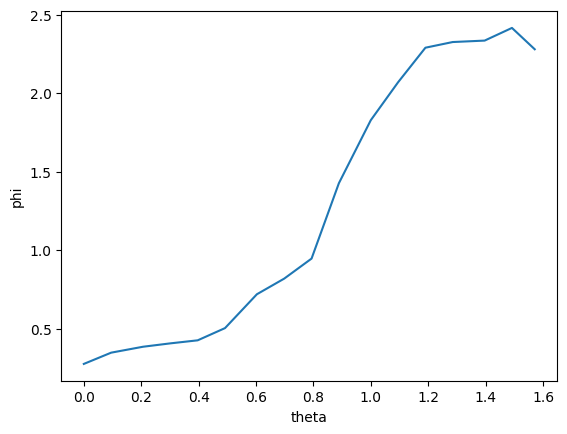

In [157]:
phi_list = []
for i in range(len(count_000)):
    phi_list.append(2*np.arctan(count_100[i]/count_000[i]) if final_0[i] != 0 else np.pi)

plt.figure()
plt.plot(thetas_actual, phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()